In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.debugger import set_trace
from importlib import reload
import matplotlib.pyplot as plt


In [13]:
import sys
sys.path.append("/Users/seanohagan/projects/conformal_tree/")
sys.path.append("/Users/seanohagan/projects/rlabc/")
from conformal_tree import conformal_tree

In [3]:
#from rlabc.treeproposal import CARTTree
#CARTTree

In [4]:
from conformal_tree._utils.tree_utils import tree_membership,tree_plotter
from conformal_tree._utils.conformal_utils import conf_plotter
from conformal_tree._data import sin_simul as data_gen
from conformal_tree._nets import network_toy as nt
reload(nt)

<module 'conformal_tree._nets.network_toy' from '/Users/seanohagan/projects/conformal_tree/conformal_tree/_nets/network_toy.py'>

In [5]:
import torch
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [6]:
from scipy.stats import norm
import pickle

q_upper=95

opt1 and opt2: (0, 1)
opt1 and opt2: (1, 0)
opt1 and opt2: (1, 1)


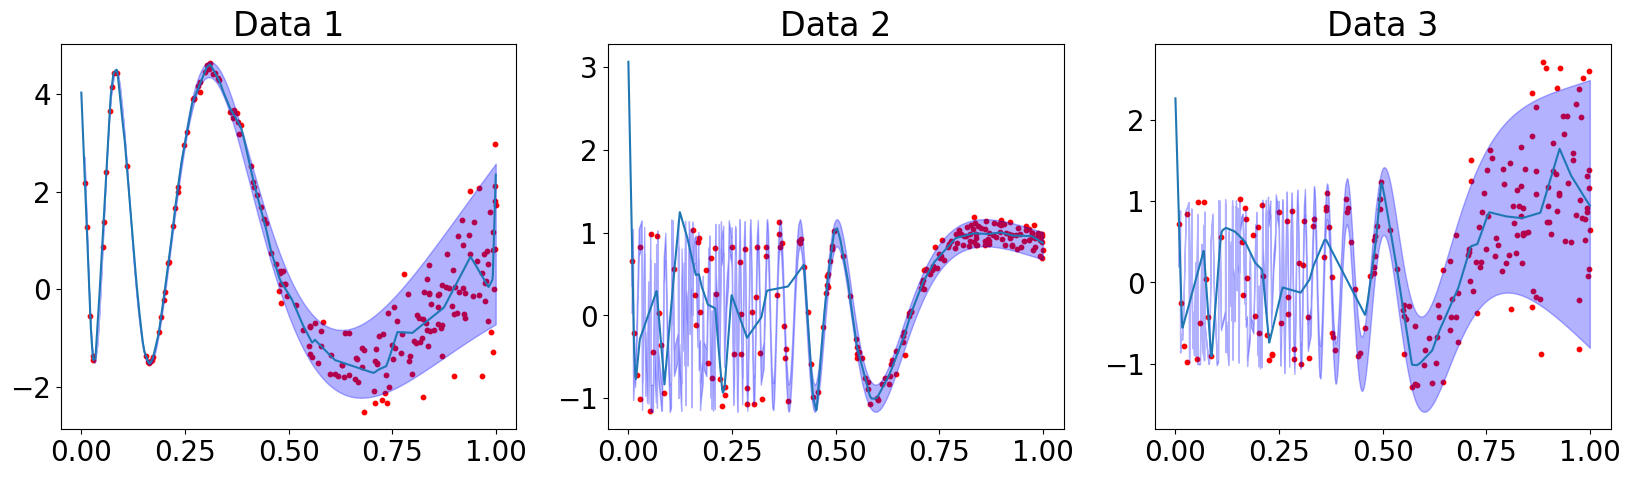

In [7]:
plt.rcParams.update({'font.size': 20})
fig, axis = plt.subplots(1, 3, figsize=(20,5))

for its, (opt1,opt2) in enumerate([(0,1),(1,0),(1,1)]):
    print(F"opt1 and opt2: {opt1,opt2}")
    path = F"./trained_nets/sin_opt{opt1}{opt2}.net"
    net = nt.MLP(input_dim=1, out_dim=1, device = DEVICE, factor=128)
    net.load_state_dict(torch.load(path, map_location=DEVICE))
    net.eval()


    with open(F"./trained_nets/sin_opt{opt1}{opt2}.dat", 'rb') as file:
        cache = pickle.load(file)

    opt1,op2 = cache["opt1"], cache["opt2"]
    (x_train,y_train),(x_calib,y_calib),(x_test, y_test) = cache["data"]

    ## Error calculation
    X_calib, Y_calib = torch.from_numpy(x_calib).to(DEVICE).float(),torch.from_numpy(y_calib).to(DEVICE)

    with torch.no_grad():
        out_calib = net(X_calib).cpu().view(-1)
    error = (Y_calib.cpu().view(-1) - out_calib.view(-1)).numpy()
    #plt.bar(x_calib[:,0],error, width=0.01)

    tree_model, membership = tree_membership(x_calib, x_calib[:,0]*0)
    bin_idx = np.unique(membership)

    it = 0
    y_true_low = data_gen.cond_exp(x_test,option=opt1) - norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test,option=opt2))
    y_true_up =  data_gen.cond_exp(x_test,option=opt1) + norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test,option=opt2))
    conf_plotter(x_test[:,0], y_true_low, y_true_up,
                 test_data=(x_train[:,0],y_train), model=net, ax=axis[its], title=F"Data {its+1}")



plt.show()



opt1 and opt2: (1, 1)


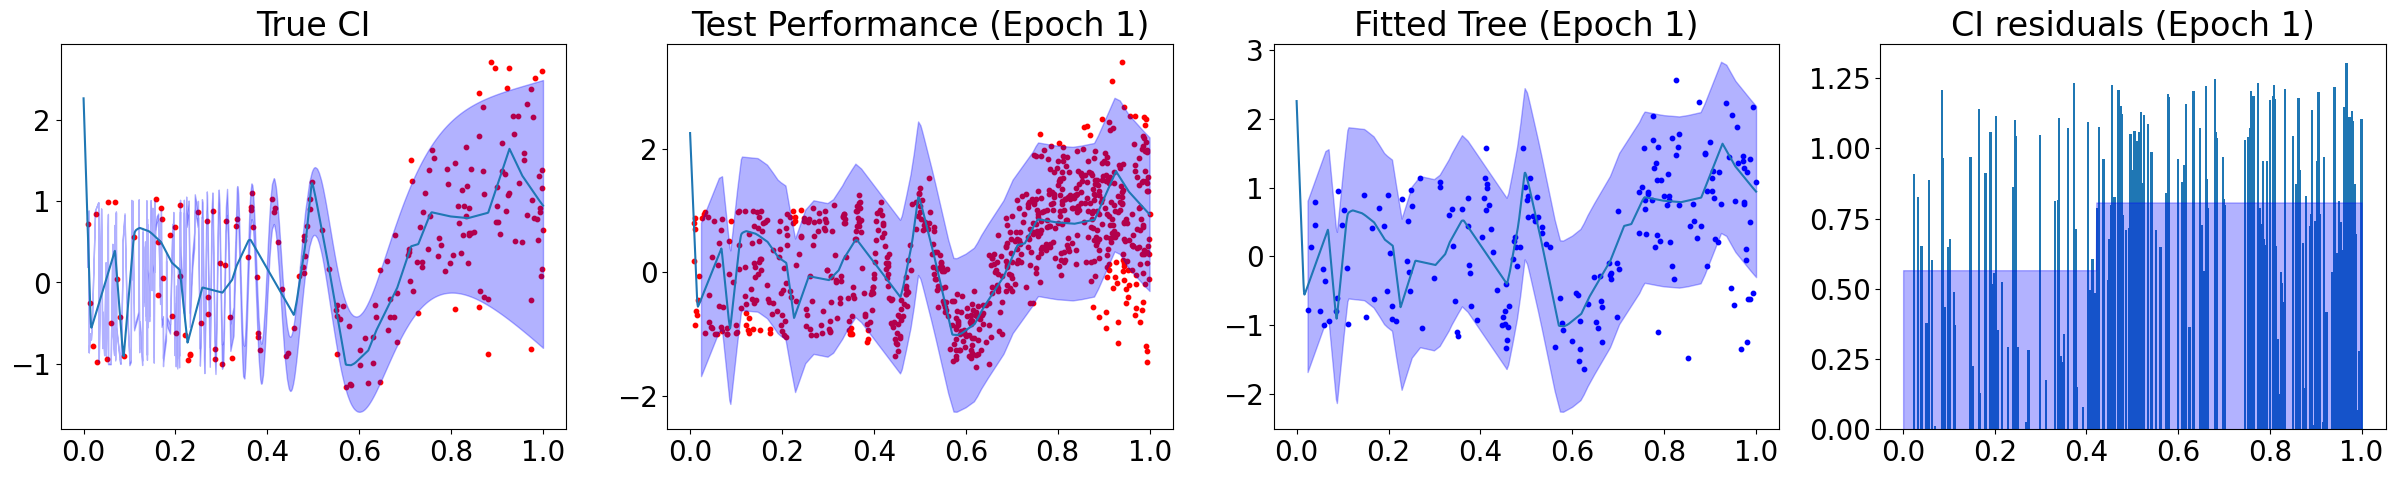

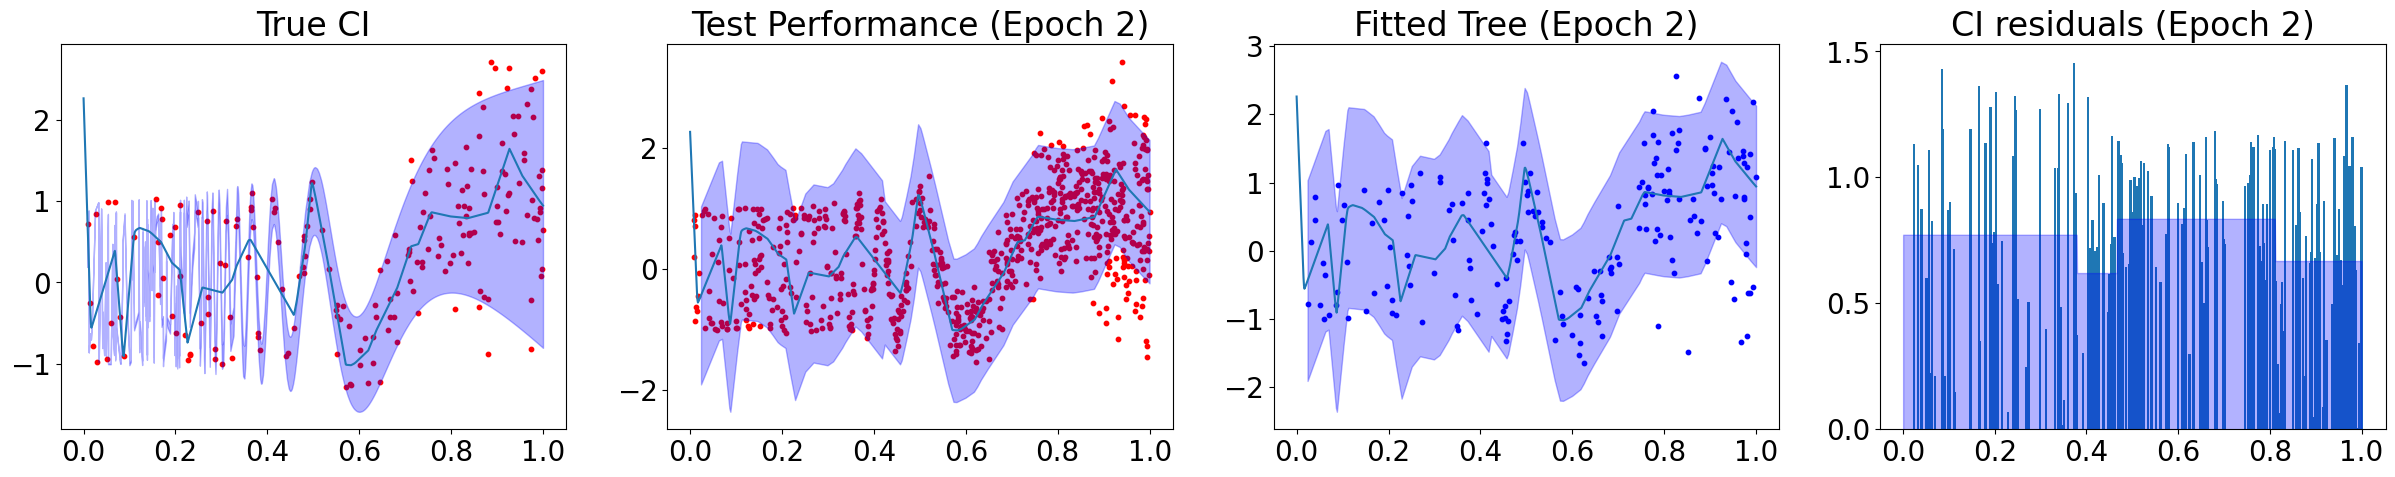

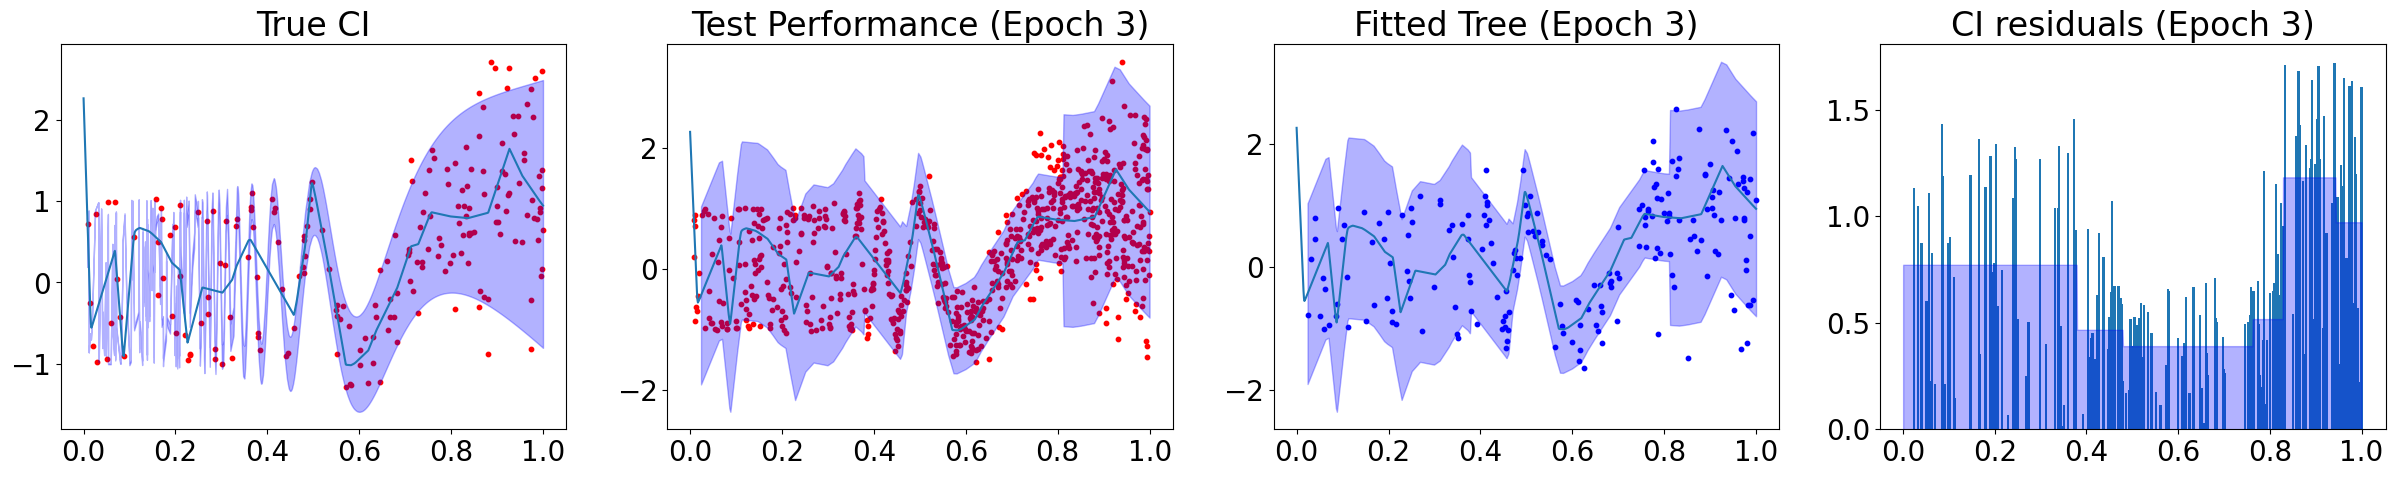

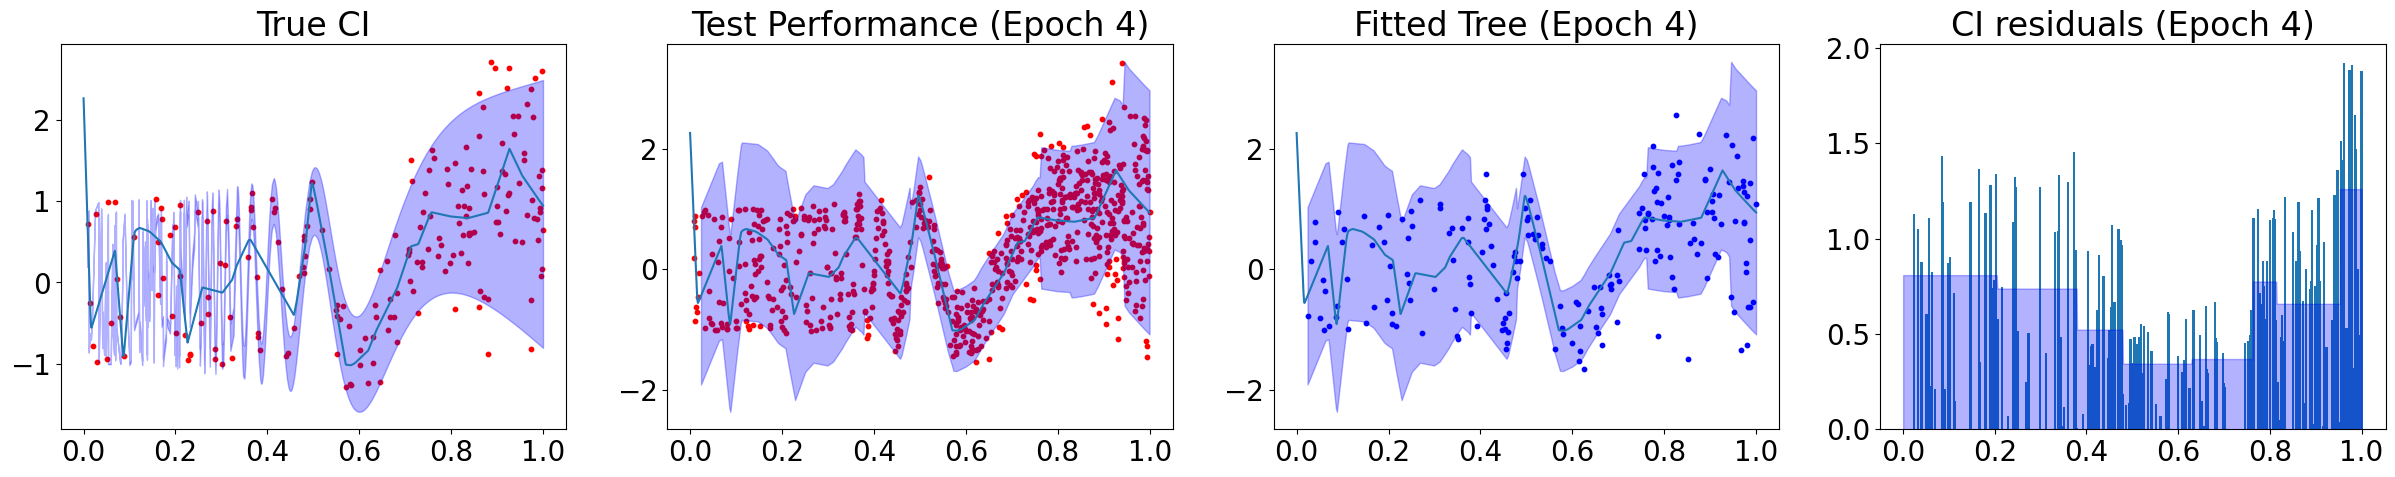

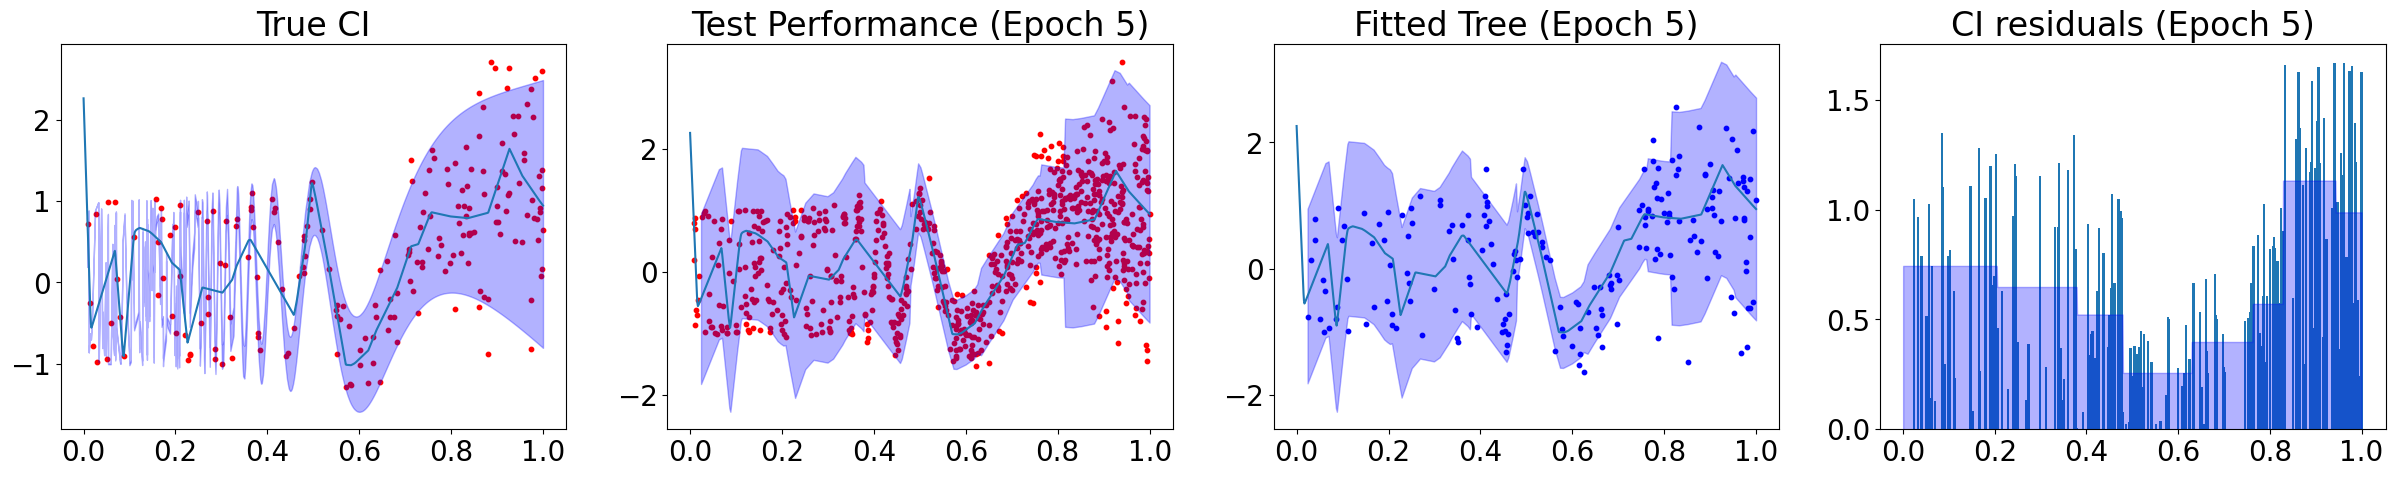

opt1 and opt2: (1, 0)


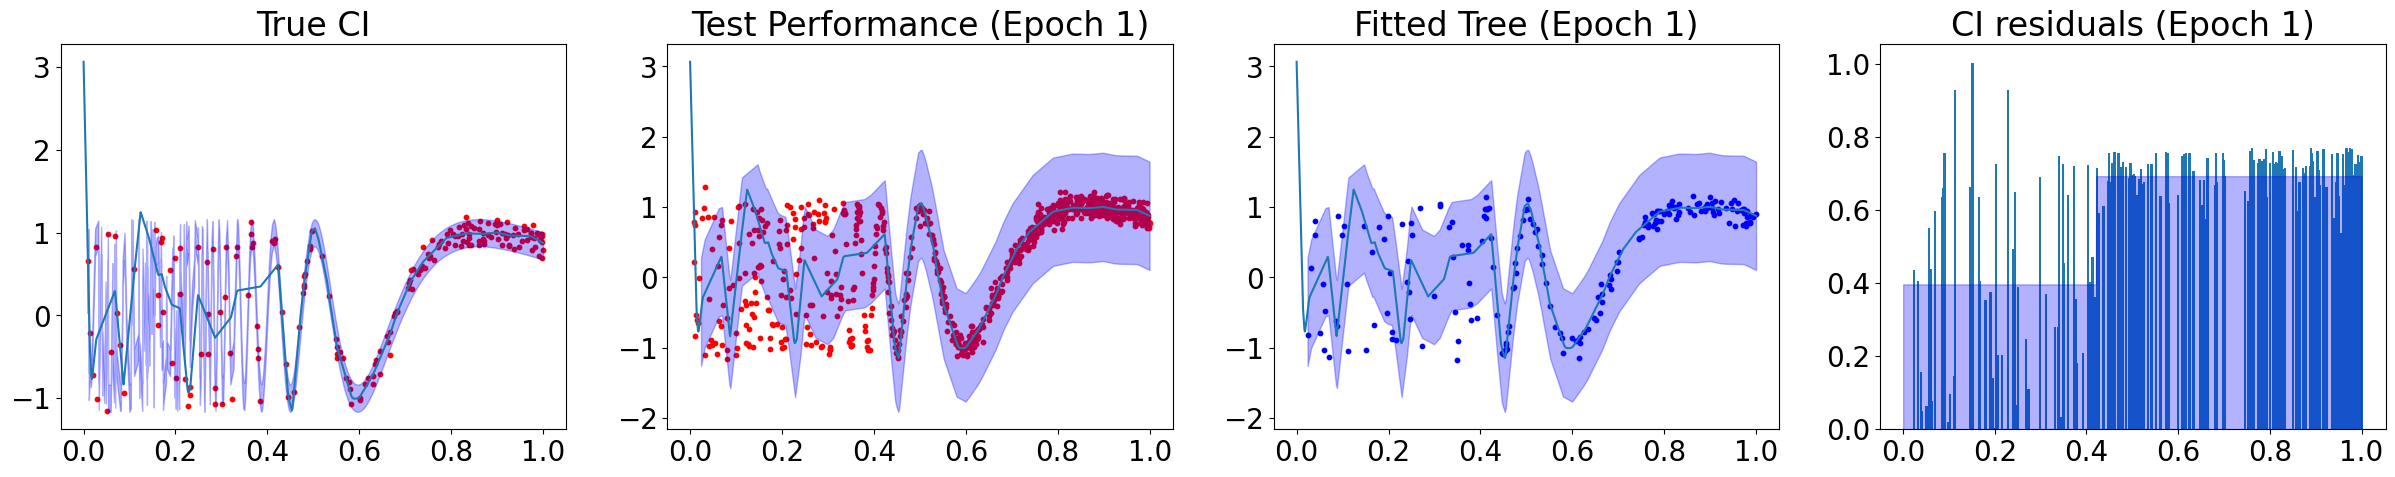

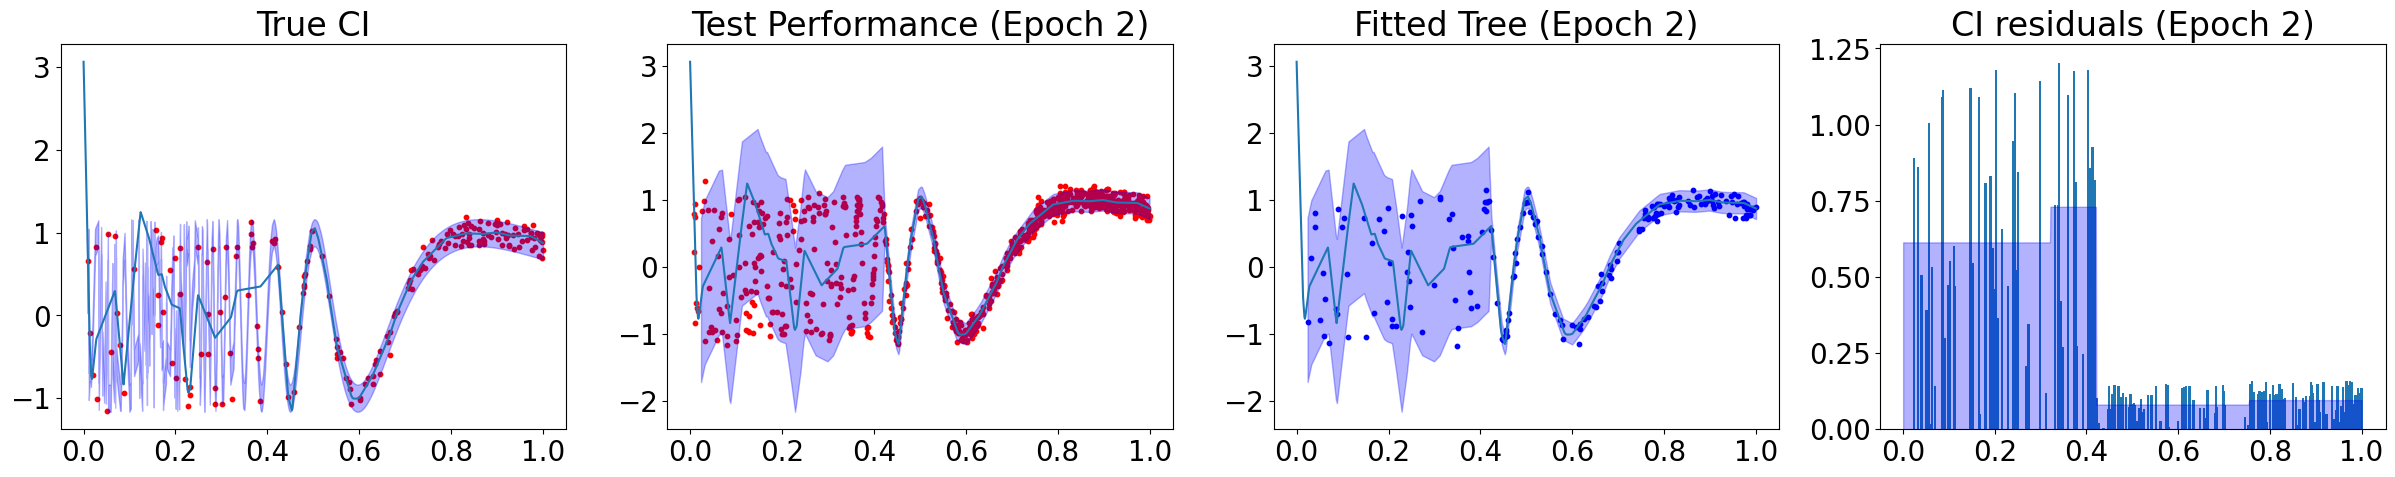

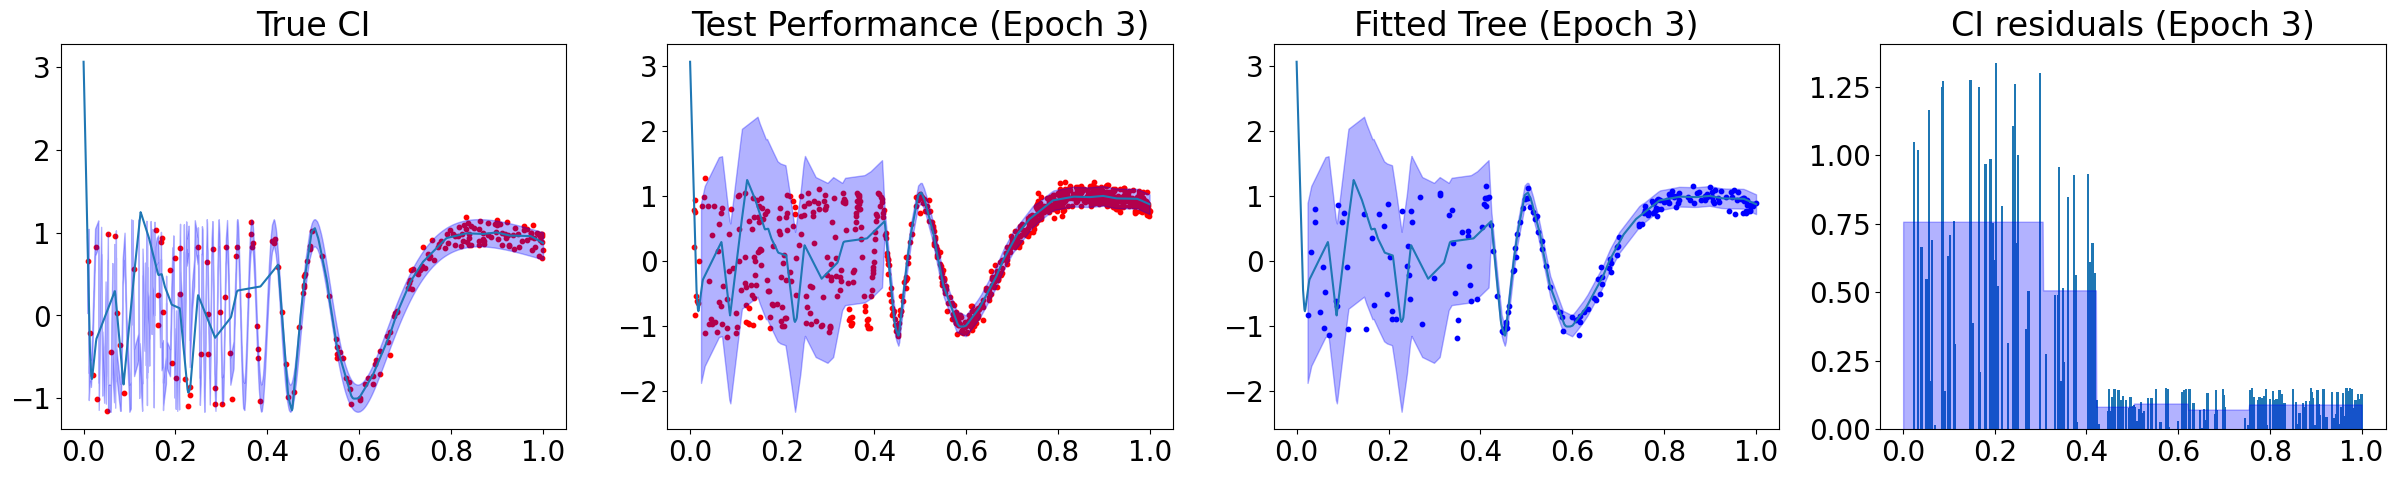

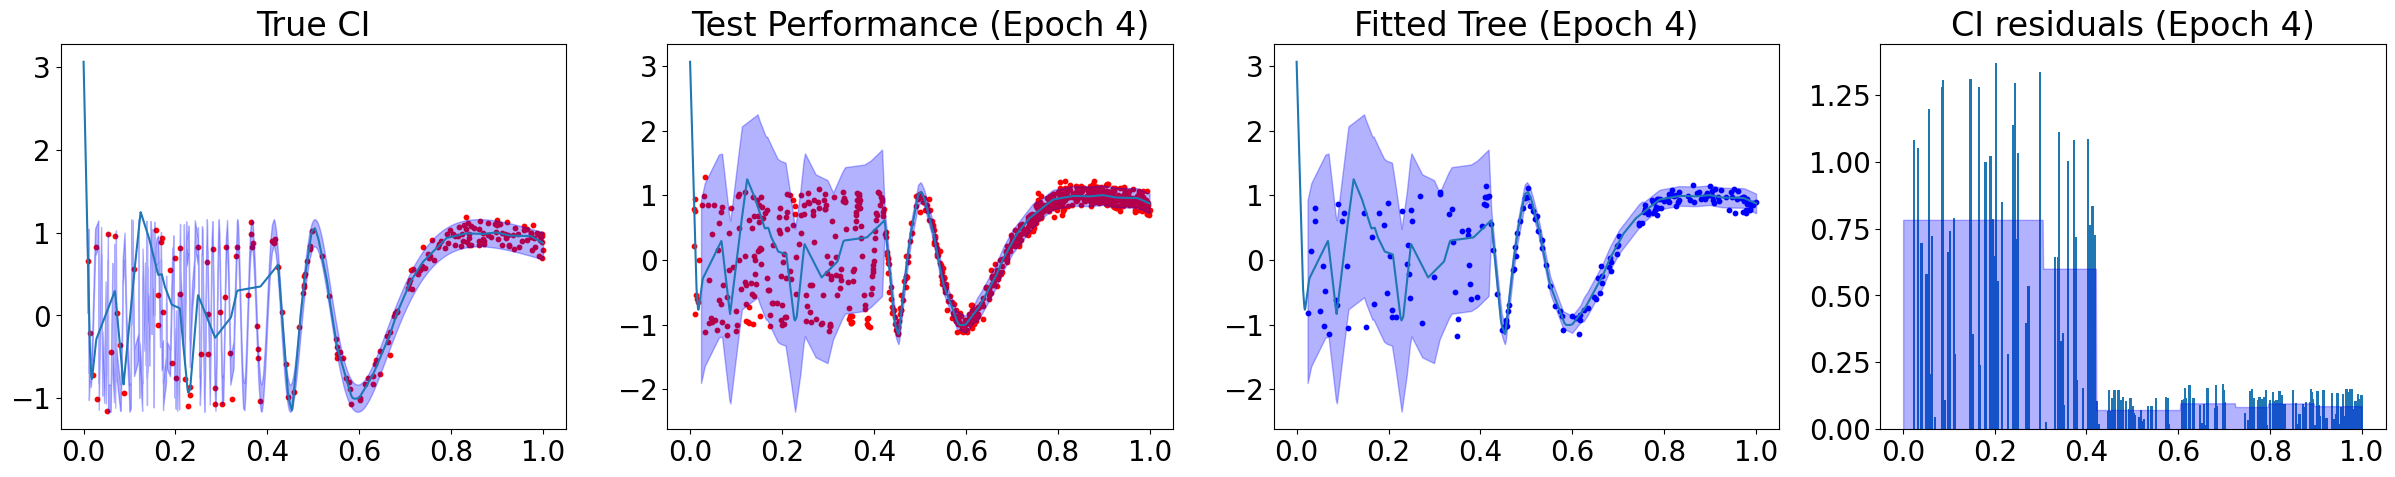

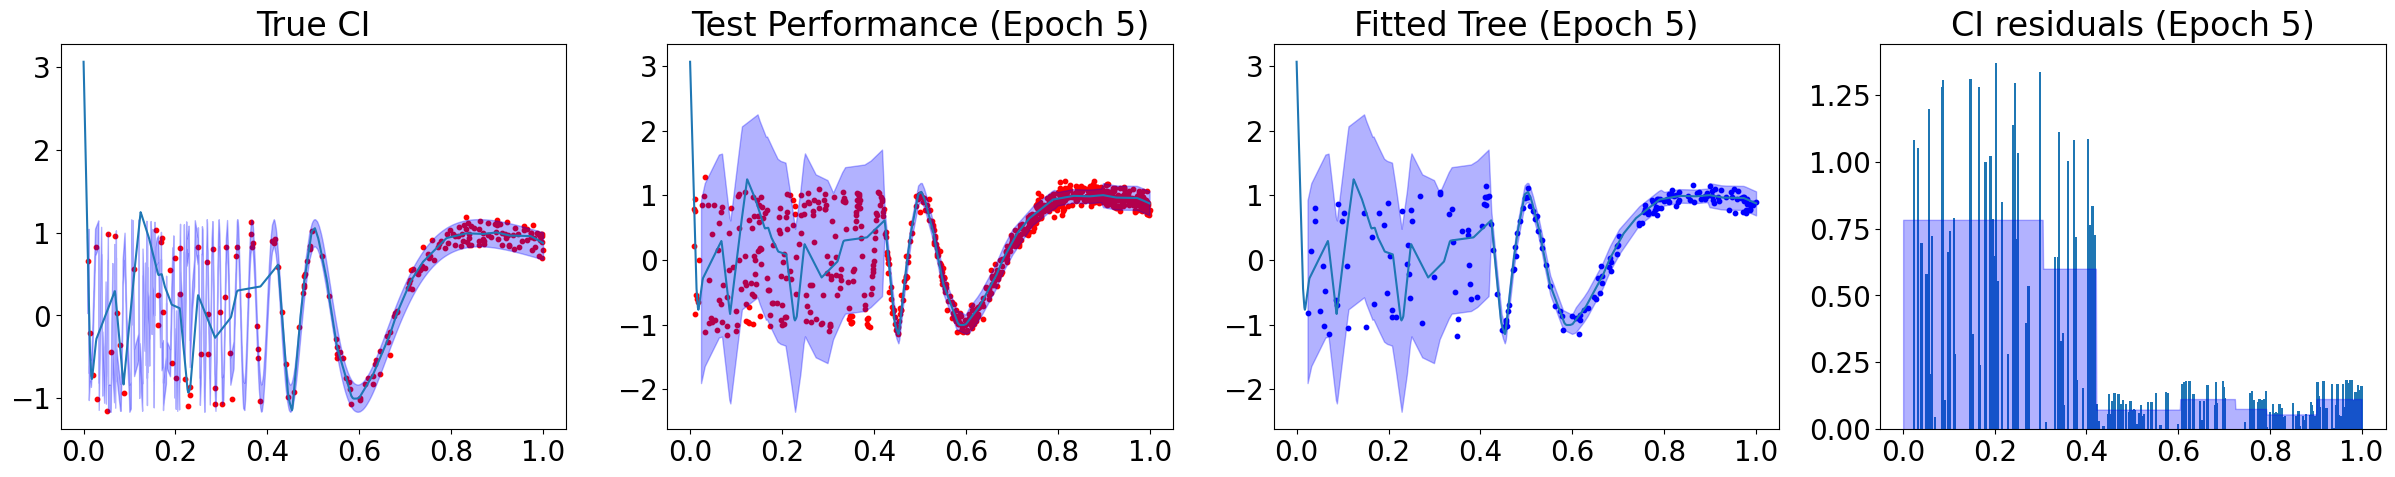

opt1 and opt2: (0, 1)


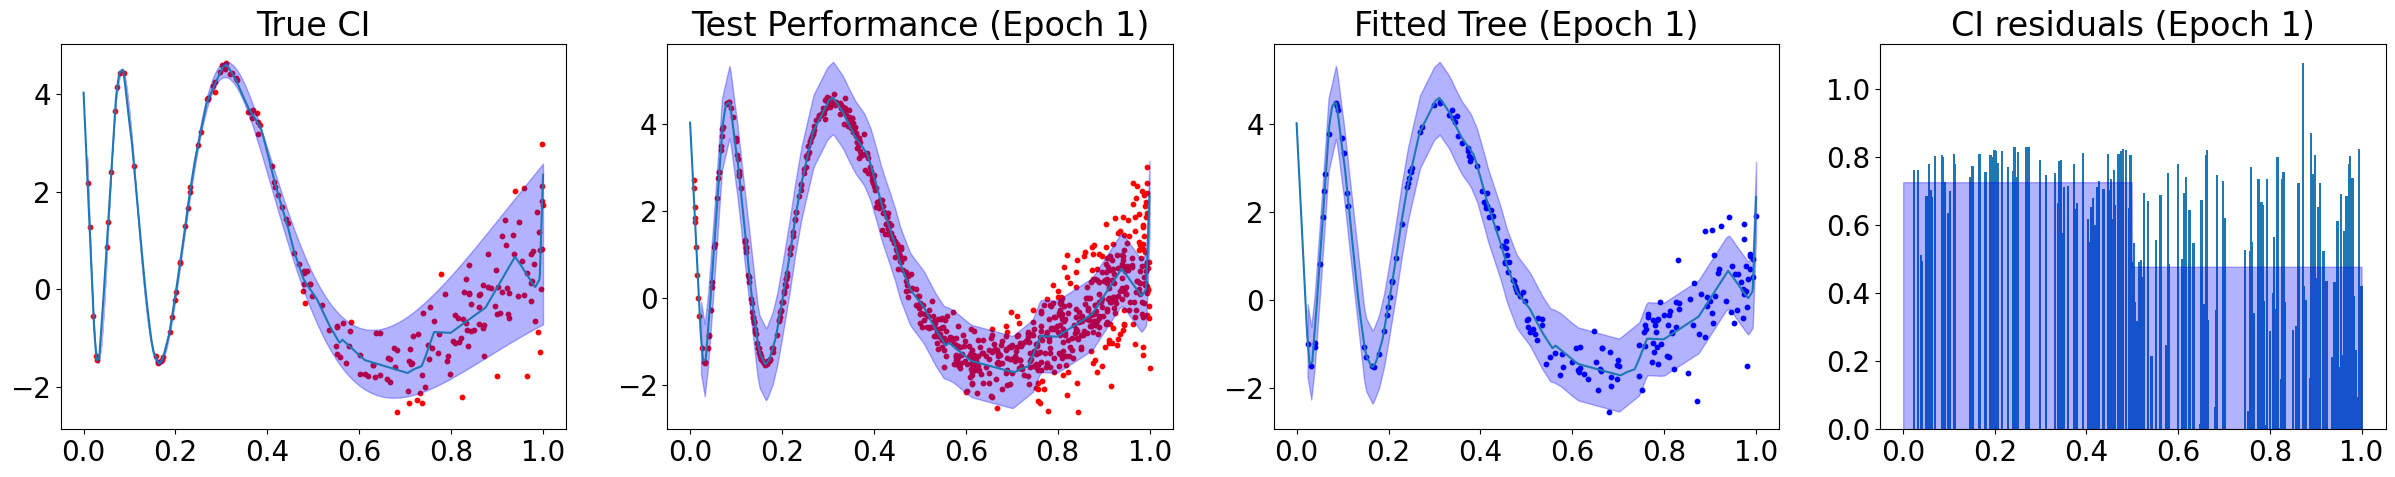

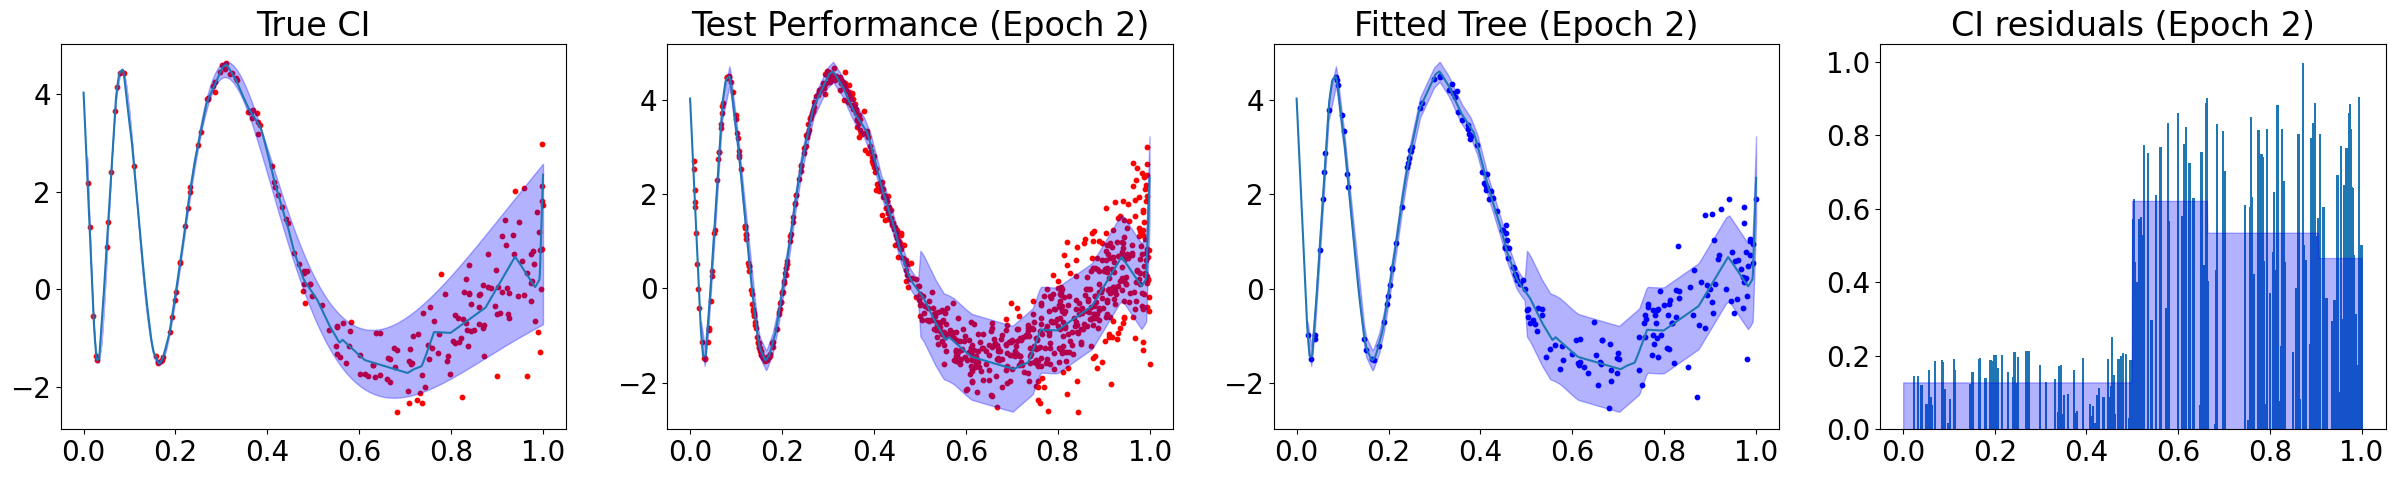

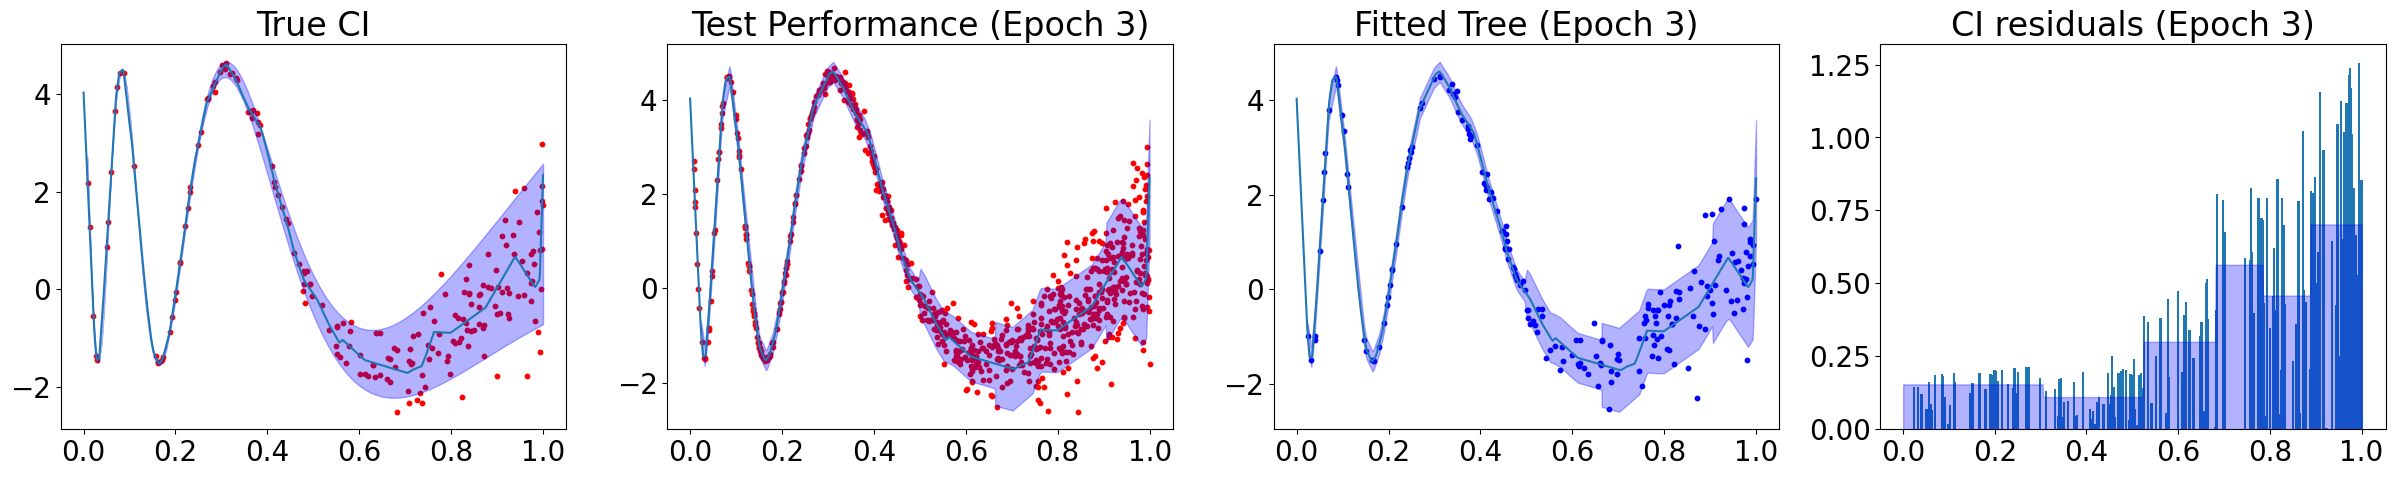

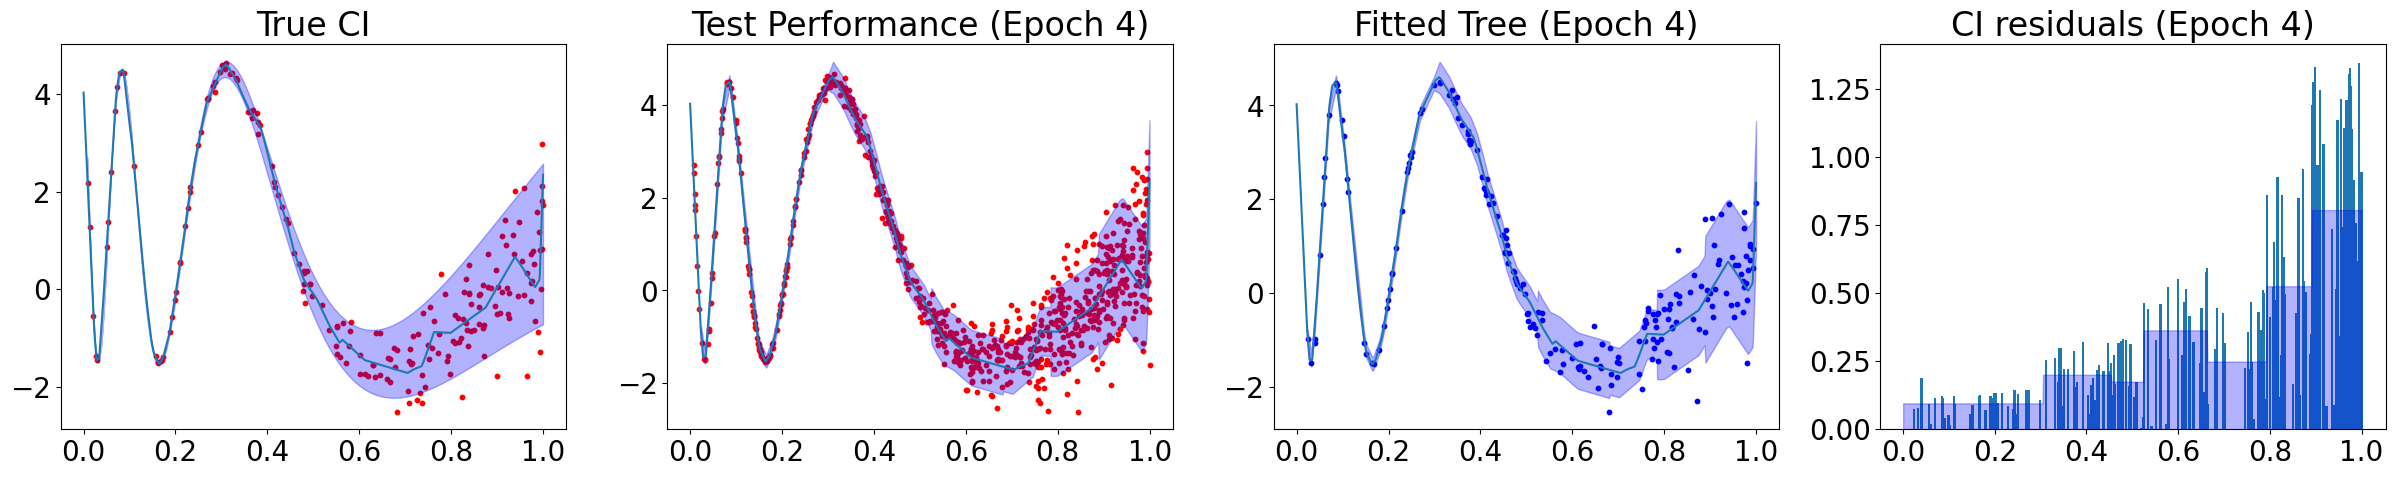

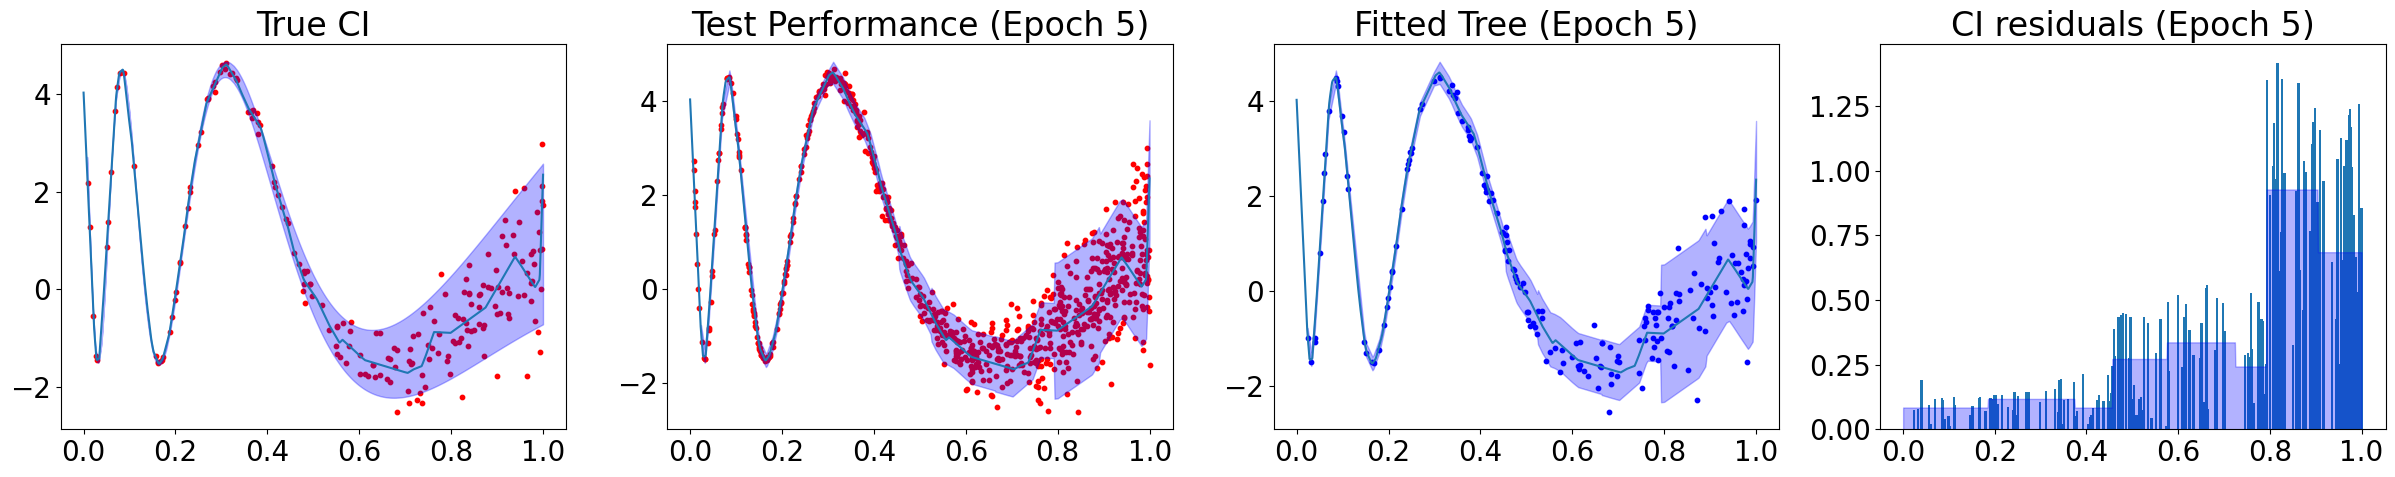

In [8]:
plt.rcParams.update({'font.size': 20})

for opt1,opt2 in [(1,1),(1,0),(0,1)]:
    print(F"opt1 and opt2: {opt1,opt2}")
    path = F"./trained_nets/sin_opt{opt1}{opt2}.net"
    net = nt.MLP(input_dim=1, out_dim=1, device = DEVICE, factor=128)
    net.load_state_dict(torch.load(path, map_location=DEVICE))
    net.eval()


    with open(F"./trained_nets/sin_opt{opt1}{opt2}.dat", 'rb') as file:
        cache = pickle.load(file)

    opt1,op2 = cache["opt1"], cache["opt2"]
    (x_train,y_train),(x_calib,y_calib),(x_test, y_test) = cache["data"]

    ## Error calculation
    X_calib, Y_calib = torch.from_numpy(x_calib).to(DEVICE).float(),torch.from_numpy(y_calib).to(DEVICE)

    with torch.no_grad():
        out_calib = net(X_calib).cpu().view(-1)
    error = (Y_calib.cpu().view(-1) - out_calib.view(-1)).numpy()
    #plt.bar(x_calib[:,0],error, width=0.01)

    tree_model, membership = tree_membership(x_calib, x_calib[:,0]*0)
    bin_idx = np.unique(membership)

    for it in range(5):
        fig, axis = plt.subplots(1, 4, figsize=(30,5))

        y_true_low = data_gen.cond_exp(x_test,option=opt1) - norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test,option=opt2))
        y_true_up =  data_gen.cond_exp(x_test,option=opt1) + norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test,option=opt2))
        conf_plotter(x_test[:,0], y_true_low, y_true_up,
                     test_data=(x_train[:,0],y_train), model=net, ax=axis[0], title="True CI")

        y_low, y_up = out_calib,out_calib
        idx_counter = 0
        indices = 0*y_low

        for idx in bin_idx:

            idx_counter +=1
            indices[membership==idx] = idx_counter

            x_subset = x_calib[membership==idx]
            error_subset = error[membership==idx]
            C = np.quantile(np.abs(error_subset), 0.90)
            y_low -= C* (membership==idx)
            y_up  += C* (membership==idx)


        #conf_plotter(x_calib[:,0],  y_low, y_up,test_data=(x_test,y_test),model=net, ax=axis[0]) #y_cal = y_calib
        conf_plotter(x_calib[:,0],  y_low, y_up,y_cal =y_calib,model=net, ax=axis[2],title=F"Fitted Tree (Epoch {it+1})") #y_cal = y_calib



        c_gap = torch.minimum((y_low-y_calib).abs(), (y_up-y_calib).abs())
        tree_model, membership = tree_membership(x_calib, c_gap, max_depth=20,
                                                 max_leaf_nodes=(it+1)*2,
                                                 min_samples_leaf=20)
        bin_idx = np.unique(membership)

        tree_plotter(tree_model,x_calib[:,0], c_gap,ax=axis[3], title=F"CI residuals (Epoch {it+1})")

        conf_plotter(x_calib[:,0],  y_low, y_up,
                     test_data=(x_test[:,0],y_test),model=net, ax=axis[1],title=F"Test Performance (Epoch {it+1})")  #y_cal = y_calib

        plt.show()


In [20]:
ct.offsets

(200, 1)

opt1 and opt2: (0, 1)
Total classes: 3
opt1 and opt2: (1, 0)
Total classes: 3
opt1 and opt2: (1, 1)
Total classes: 3


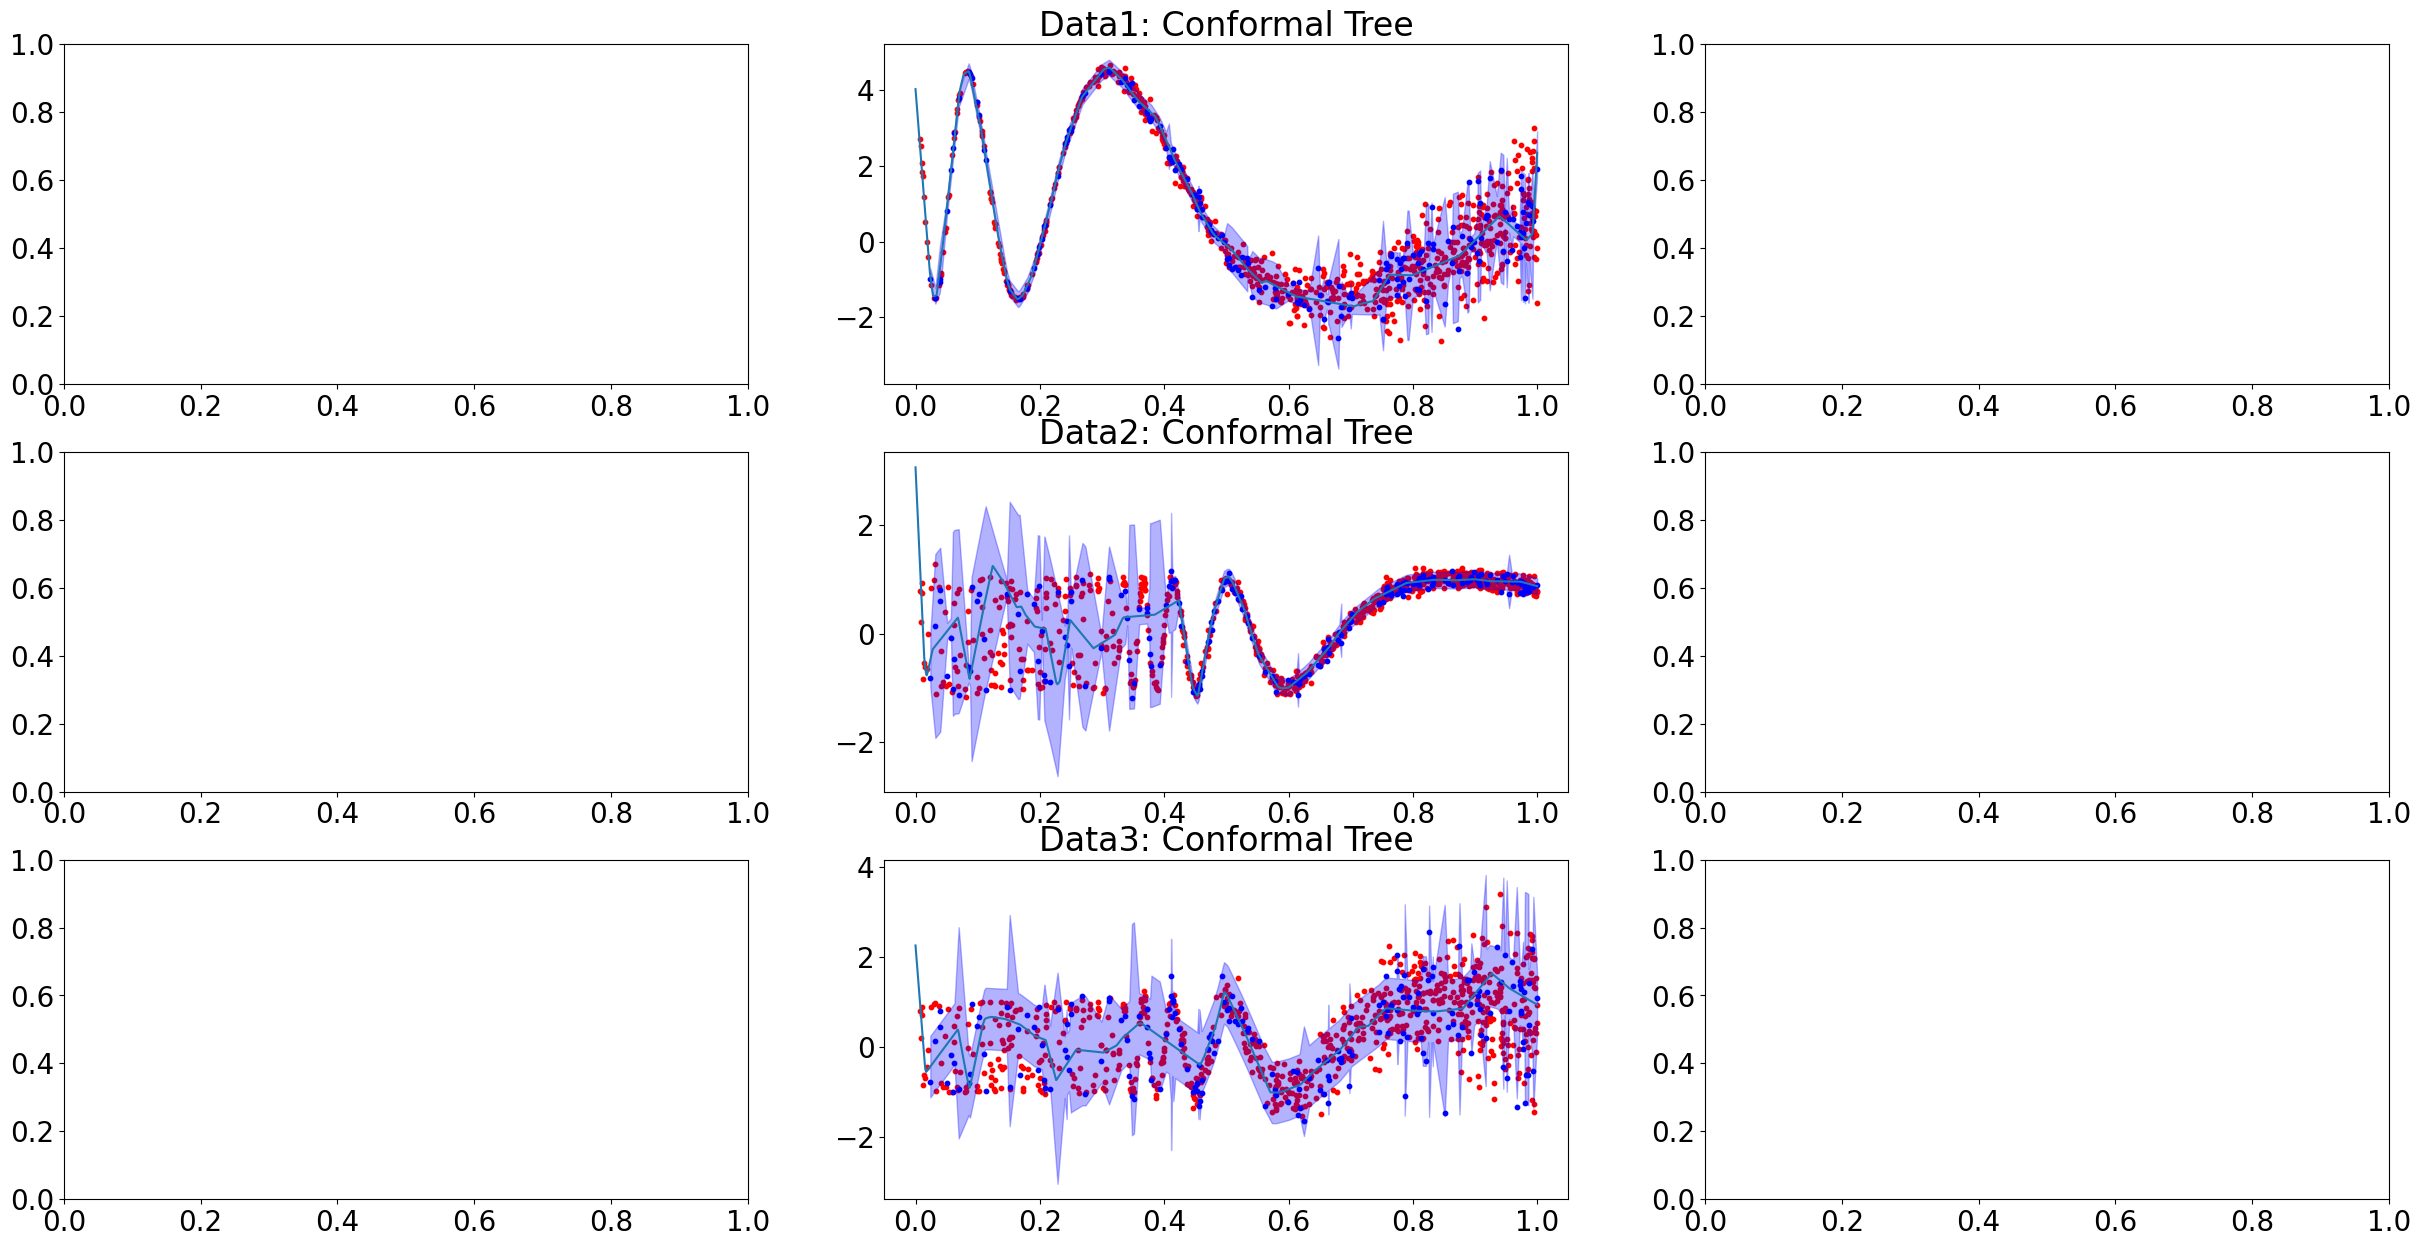

In [31]:

plt.rcParams.update({'font.size': 20})
fig, axis = plt.subplots(3, 3, figsize=(30,15))

for its,(opt1,opt2) in enumerate([(0,1),(1,0),(1,1)]):
    print(F"opt1 and opt2: {opt1,opt2}")
    path = F"./trained_nets/sin_opt{opt1}{opt2}.net"
    net = nt.MLP(input_dim=1, out_dim=1, device = DEVICE, factor=128)
    net.load_state_dict(torch.load(path,map_location=DEVICE))
    net.eval()


    with open(F"./trained_nets/sin_opt{opt1}{opt2}.dat", 'rb') as file:
        cache = pickle.load(file)

    opt1,op2 = cache["opt1"], cache["opt2"]
    (x_train,y_train),(x_calib,y_calib),(x_test, y_test) = cache["data"]

    ## Error calculation
    X_calib, Y_calib = torch.from_numpy(x_calib).to(DEVICE).float(),torch.from_numpy(y_calib).to(DEVICE)

    domain = np.array([[0.,1.]])
    class LambdaModel:
        def predict(self, x):
            with torch.no_grad():
                return net(torch.from_numpy(x).to(DEVICE)).cpu().numpy()
    model_obj = LambdaModel()
    ct = conformal_tree.ConformalClassifier(model_obj, domain)
    X_calib_np = X_calib.cpu().numpy()
    ct.calibrate(X_calib_np, Y_calib.cpu().numpy(), model_obj.predict(X_calib_np).flatten(), alpha=0.1)
    y_low, y_up = ct.test_interval(X_calib.cpu().numpy())
    title = F"Data{its+1}: Conformal Tree"
    conf_plotter(x_calib[:,0],  y_low, y_up,y_cal =y_calib,test_data=(x_test[:,0],y_test),
                 model=net, ax=axis[its,max(0,0+(it//4)*2-1)],title=title) #y_cal = y_calib


plt.show()



# Below: sean learning

In [19]:
x_calib[:,0]*0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

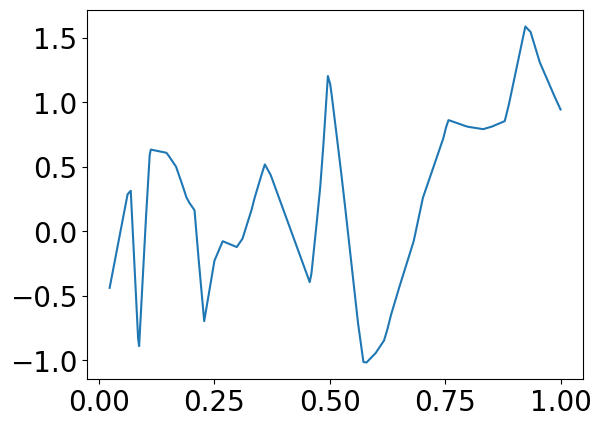

In [28]:
sorted_idxs = np.argsort(x_calib[:,0])
plt.plot(x_calib[:,0][sorted_idxs], out_calib[sorted_idxs])
plt.show()

### Fits a decision tree to the calibration data and given response data

In the initial stage, the tree response is all zeros

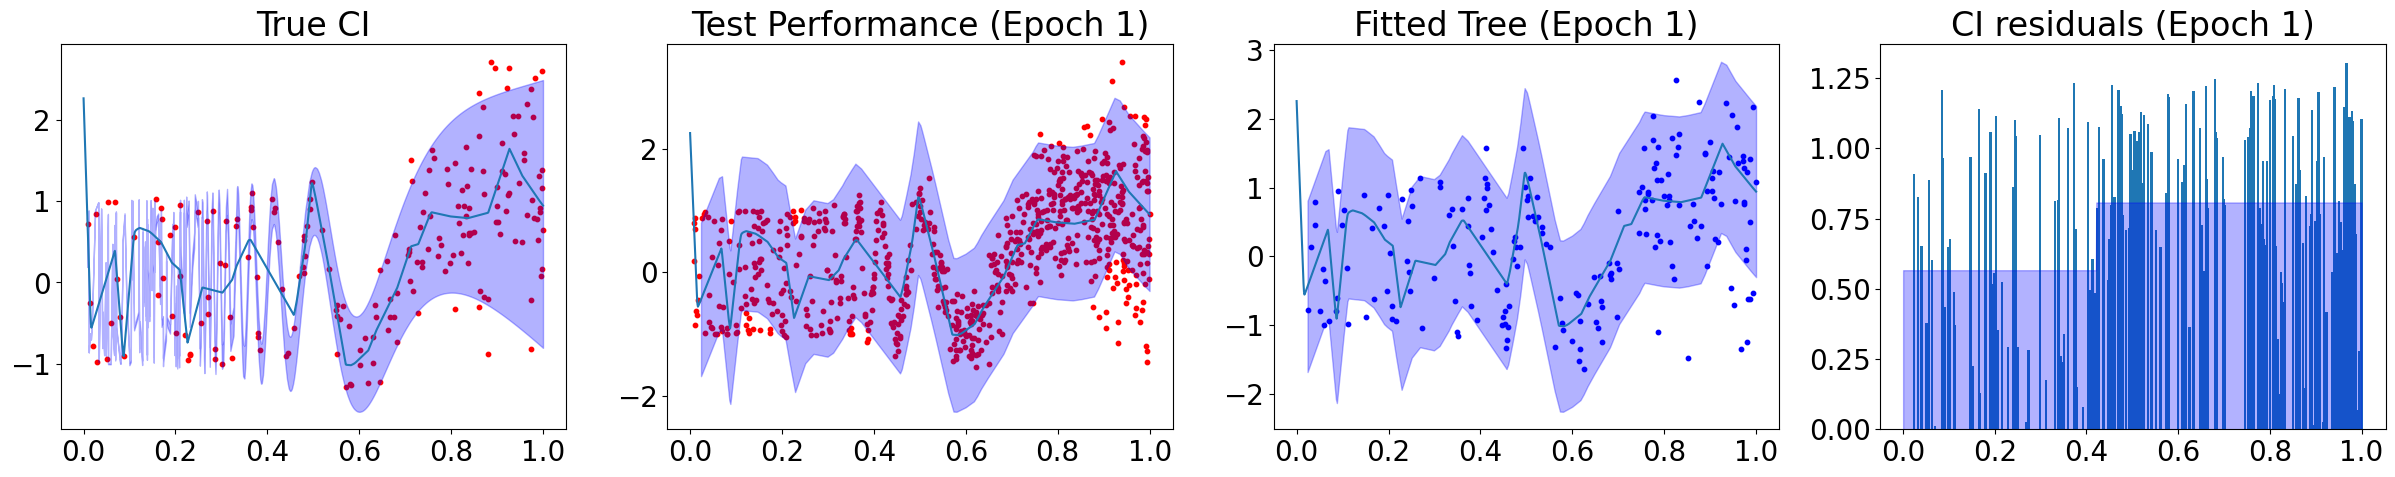

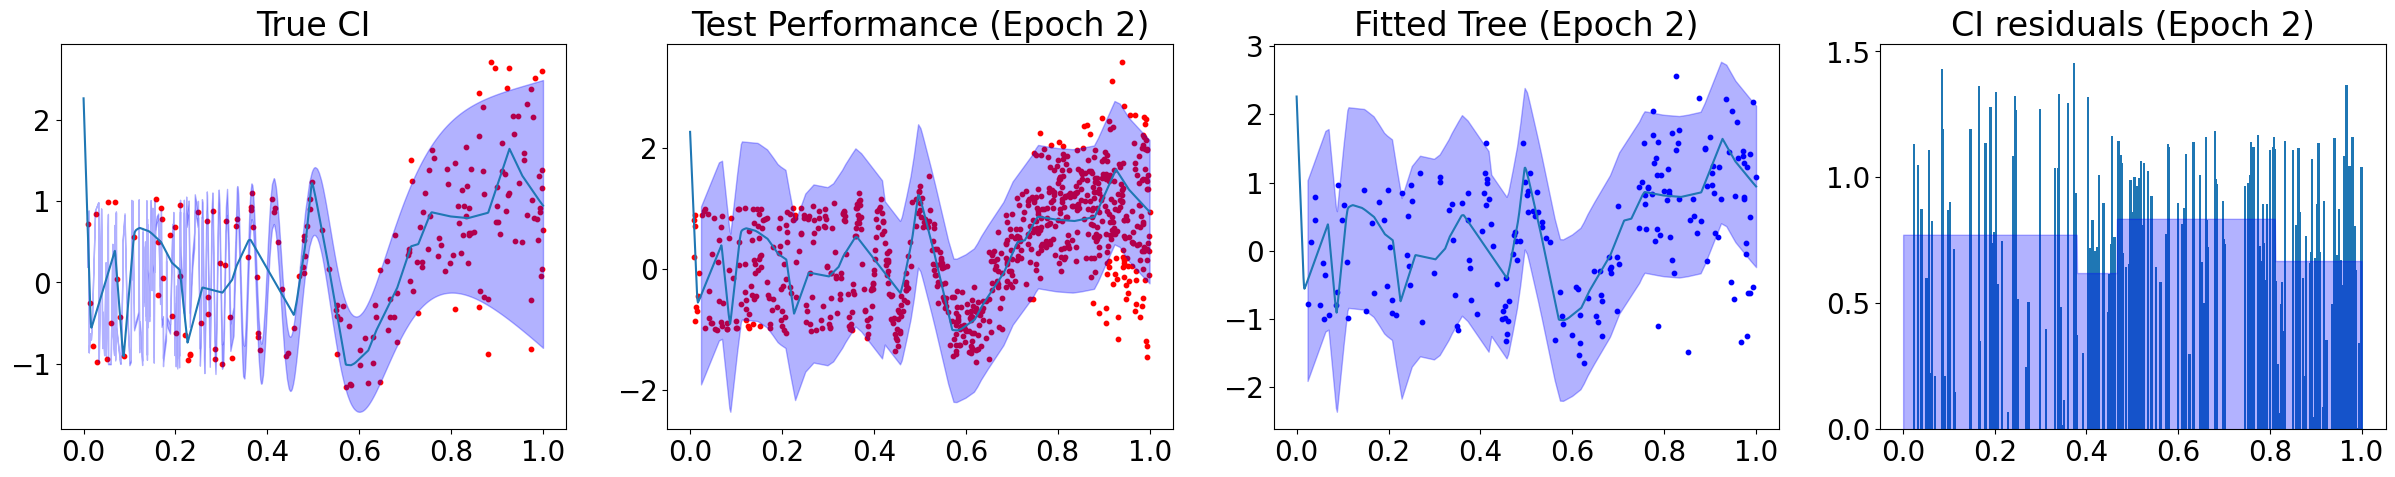

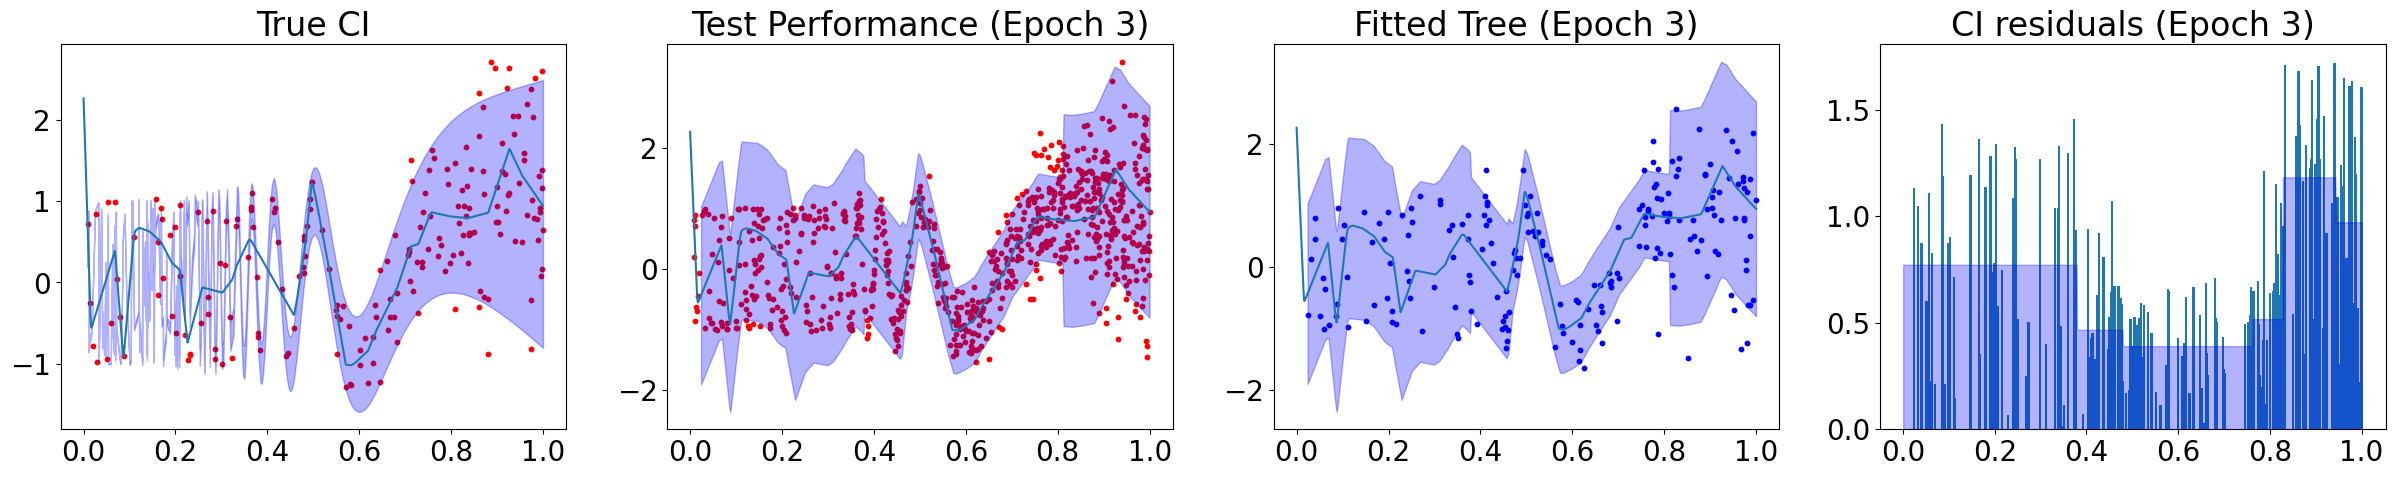

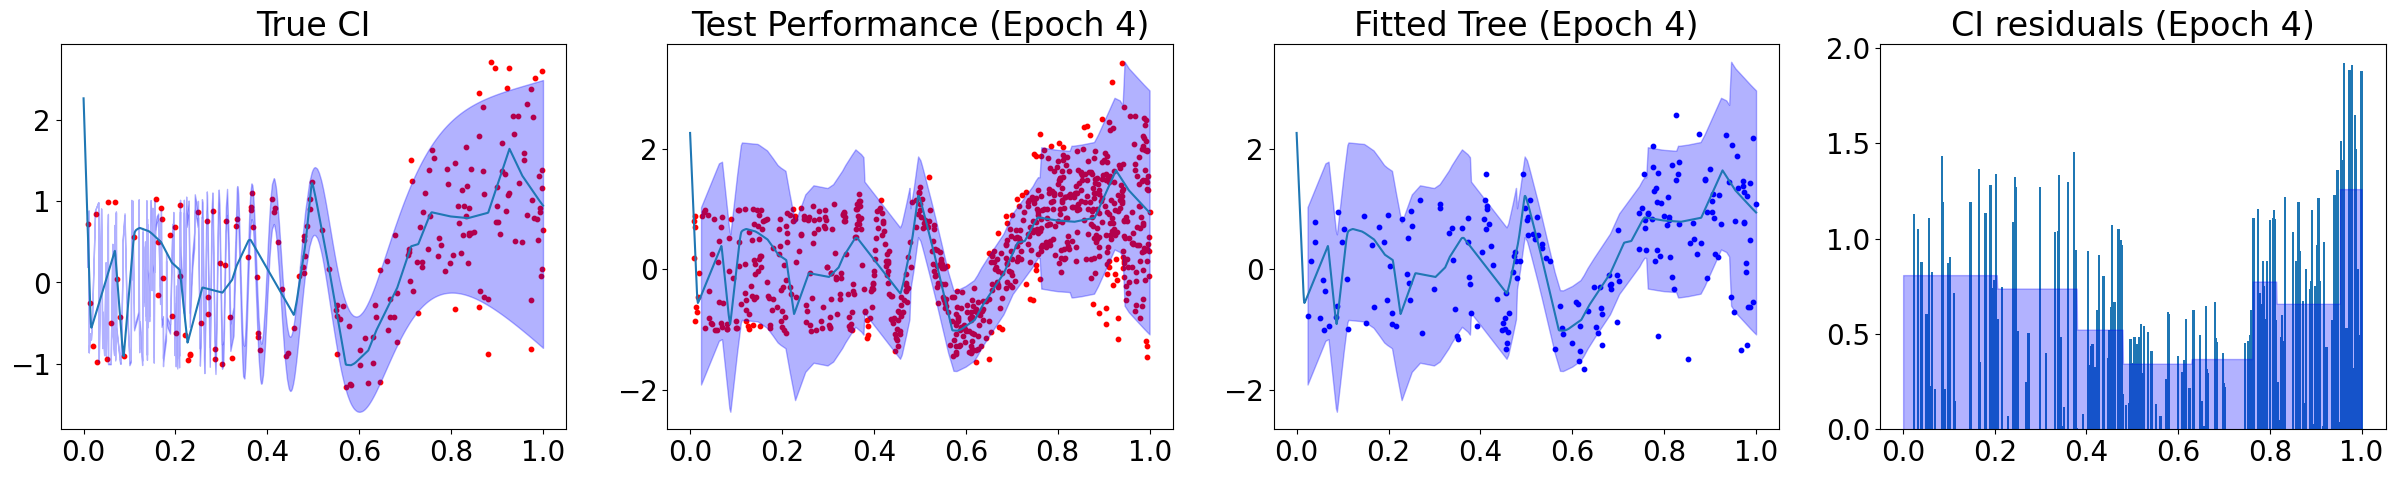

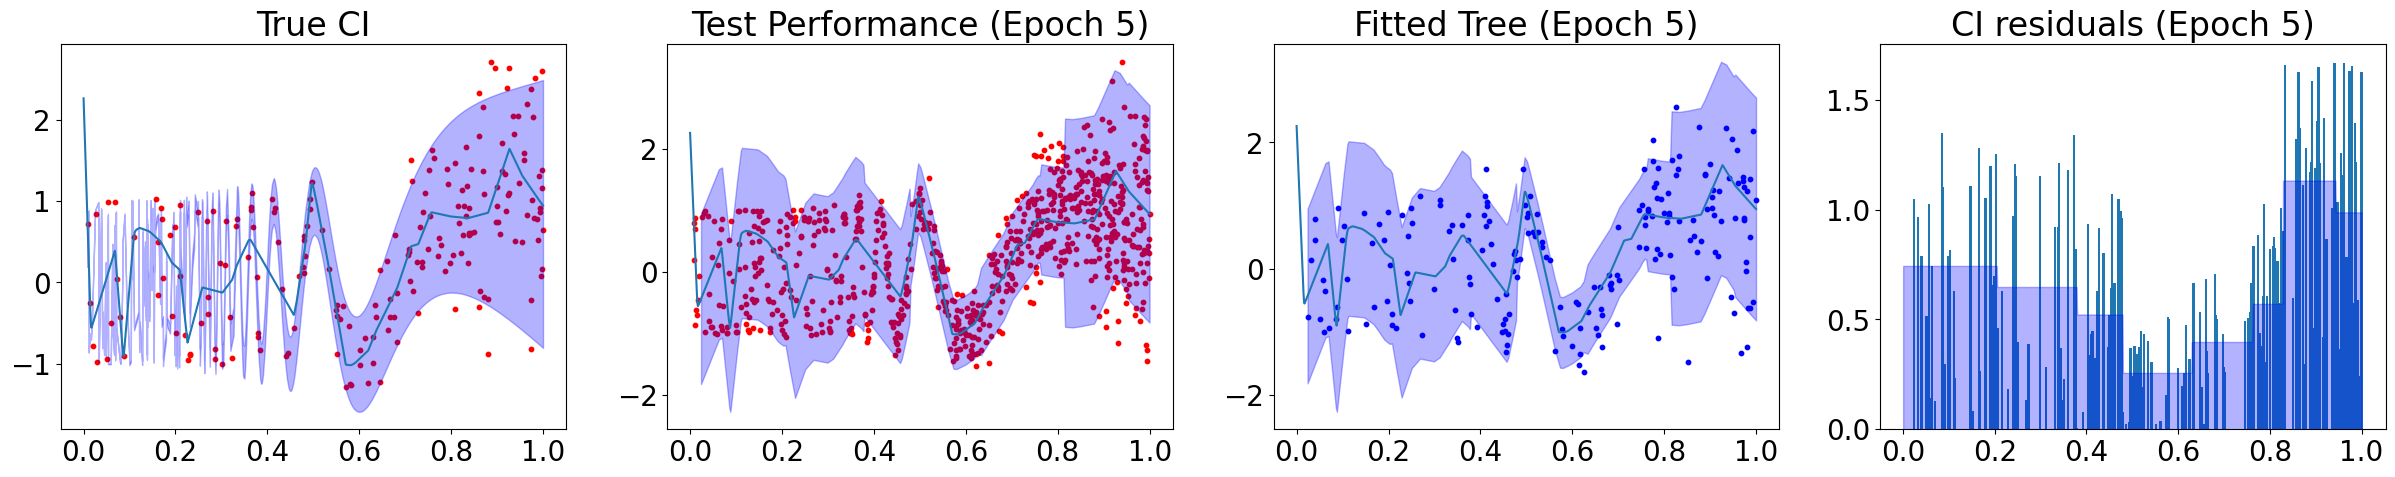

In [167]:
tree_model, membership = tree_membership(x_calib, x_calib[:,0]*0)
bin_idx = np.unique(membership)
for it in range(5):
    fig, axis = plt.subplots(1, 4, figsize=(30,5))

    # True 95% CI upper and loewr bounds based on the data generating process
    y_true_low = data_gen.cond_exp(x_test,option=opt1) - norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test,option=opt2))
    y_true_up =  data_gen.cond_exp(x_test,option=opt1) + norm.ppf(q_upper/100, 0, data_gen.noise_sd_fn(x_test,option=opt2))
    conf_plotter(x_test[:,0], y_true_low, y_true_up,
                 test_data=(x_train[:,0],y_train), model=net, ax=axis[0], title="True CI")

    # Initialize the lower and upper bounds to be simply the model prediction
    y_low, y_up = out_calib,out_calib

    # For each bin
    for idx in bin_idx:

        # Take the subset of data points that were in the bin
        # x_subset = x_calib[membership==idx]

        # Take the errors on this subset
        # Error is the residuals on the model
        error_subset = error[membership==idx]

        # C is the 0.9 quantile of errors inside this bin
        C = np.quantile(np.abs(error_subset), 0.90)

        # We increment/decrement the boundaries by C
        y_low -= C* (membership==idx)
        y_up  += C* (membership==idx)


        #conf_plotter(x_calib[:,0],  y_low, y_up,test_data=(x_test,y_test),model=net, ax=axis[0]) #y_cal = y_calib
    conf_plotter(x_calib[:,0],  y_low, y_up,y_cal =y_calib,model=net, ax=axis[2],title=F"Fitted Tree (Epoch {it+1})") #y_cal = y_calib



    c_gap = torch.minimum((y_low-y_calib).abs(), (y_up-y_calib).abs())
    tree_model, membership = tree_membership(x_calib, c_gap, max_depth=20,
                                             max_leaf_nodes=(it+1)*2,
                                             min_samples_leaf=20)
    bin_idx = np.unique(membership)

    tree_plotter(tree_model,x_calib[:,0], c_gap,ax=axis[3], title=F"CI residuals (Epoch {it+1})")

    conf_plotter(x_calib[:,0],  y_low, y_up,
                 test_data=(x_test[:,0],y_test),model=net, ax=axis[1],title=F"Test Performance (Epoch {it+1})")  #y_cal = y_calib

    plt.show()



In [179]:
from conformal_tree import conformal_tree
reload(conformal_tree)

<module 'conformal_tree.conformal_tree' from '/Users/seanohagan/projects/conformal_tree/conformal_tree/conformal_tree.py'>

In [180]:
ct = conformal_tree.CTree(1)

In [181]:
y_lb, y_ub, c_gap2 = ct.calibrate(X_calib.numpy(), y_calib, out_calib.numpy(), 0.1)

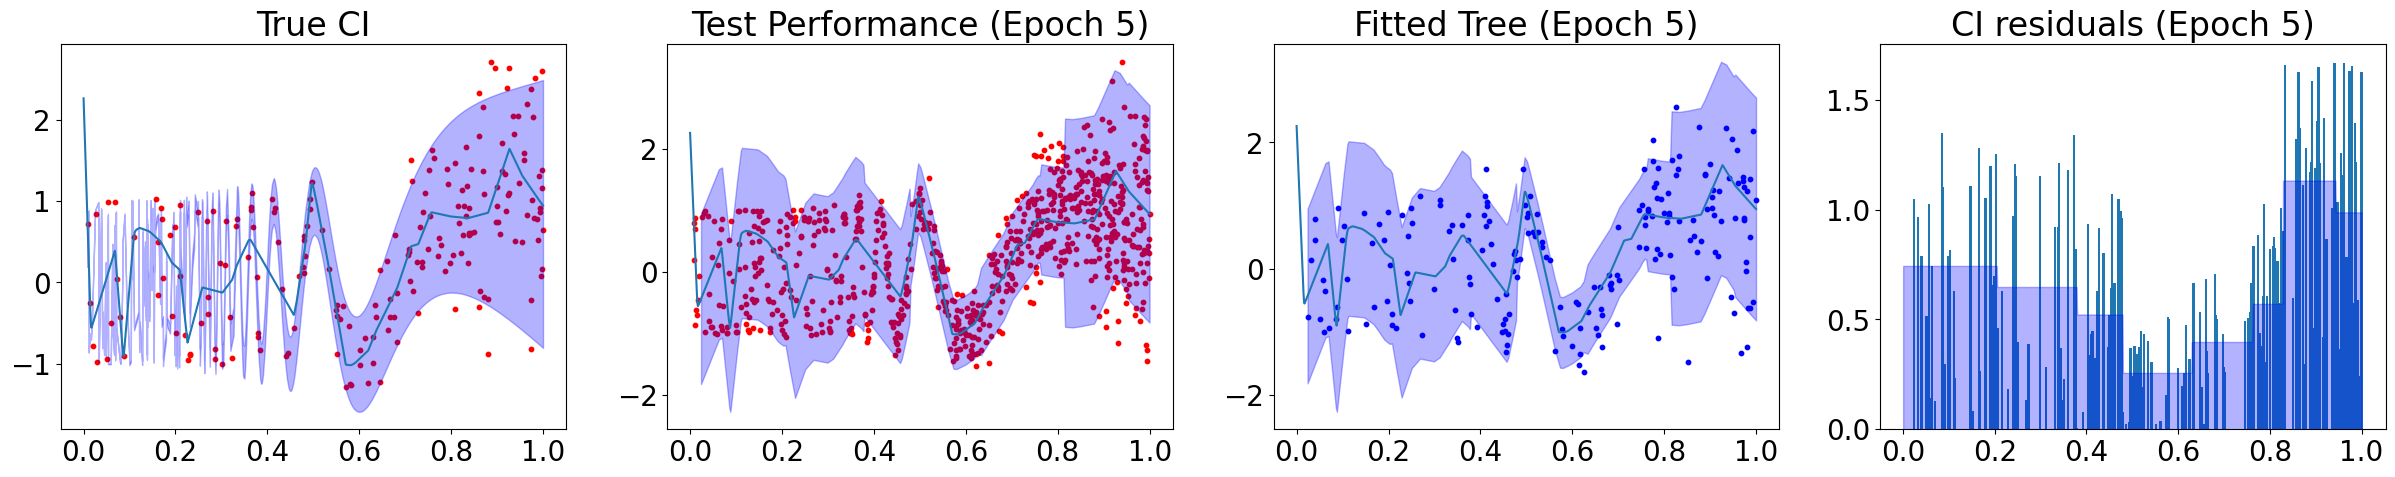

In [182]:
fig, axis = plt.subplots(1, 4, figsize=(30,5))


conf_plotter(x_test[:,0], y_true_low, y_true_up,
             test_data=(x_train[:,0],y_train), model=net, ax=axis[0], title="True CI")

conf_plotter(x_calib[:,0],  y_low, y_up,
             test_data=(x_test[:,0],y_test),model=net, ax=axis[1],title=F"Test Performance (Epoch {it+1})")  #y_cal = y_calib

conf_plotter(x_calib[:,0],  y_low, y_up,y_cal =y_calib,model=net, ax=axis[2],title=F"Fitted Tree (Epoch {it+1})") #y_cal = y_calib

tree_plotter(tree_model,x_calib[:,0], c_gap,ax=axis[3], title=F"CI residuals (Epoch {it+1})")

plt.show()

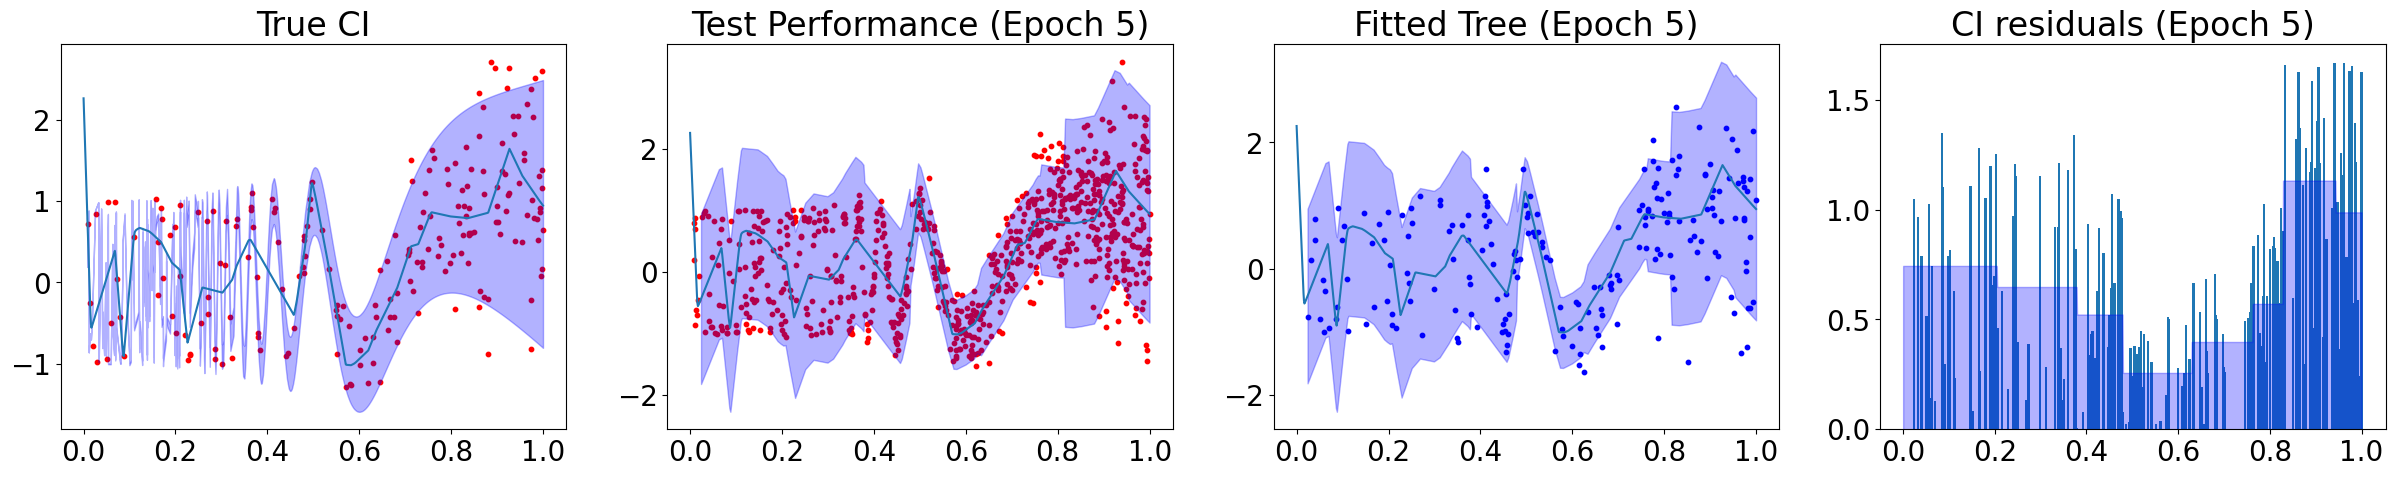

In [183]:
fig, axis = plt.subplots(1, 4, figsize=(30,5))


conf_plotter(x_test[:,0], y_true_low, y_true_up,
             test_data=(x_train[:,0],y_train), model=net, ax=axis[0], title="True CI")

conf_plotter(x_calib[:,0],  y_lb, y_ub,
             test_data=(x_test[:,0],y_test),model=net, ax=axis[1],title=F"Test Performance (Epoch {it+1})")  #y_cal = y_calib

conf_plotter(x_calib[:,0],  y_lb, y_ub, y_cal =y_calib,model=net, ax=axis[2],title=F"Fitted Tree (Epoch {it+1})") #y_cal = y_calib

tree_plotter(tree_model,x_calib[:,0], c_gap2,ax=axis[3], title=F"CI residuals (Epoch {it+1})")

plt.show()

In [102]:
y_up.shape

torch.Size([200])

In [103]:
y_lb.shape

(200,)